In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time as ti
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint



2025-05-31 09:45:34.039051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748684734.242653      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748684734.297747      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os 
mediu_sw_calcul='tensorflow' # "jax" sau "tensorflow" sau "torch"
# selectie backend (daca nu se apeleaza - ramane implicit tensorflow)
os.environ["KERAS_BACKEND"] = mediu_sw_calcul
# verificare backend 
import keras
import tensorflow as tf 
import numpy as np 
print('Backend: ',keras.config.backend())
print('Keras version: ',keras.__version__)

Backend:  tensorflow
Keras version:  3.5.0


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_dir = '/kaggle/input/plantvillage-dataset/color'  
output_dir = '/kaggle/working/split-dataset' 

splits = ['train', 'val', 'test']
split_ratios = {'train': 0.7, 'val': 0.2, 'test': 0.1} 

for split in splits:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    images = [img for img in images if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratios['train']), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(split_ratios['test'] / (split_ratios['val'] + split_ratios['test'])), random_state=42)

    split_data = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}

    for split, imgs in split_data.items():
        split_class_path = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_path, exist_ok=True) 

        for img in imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_path, img)
            shutil.copy2(src, dst) 

print("Dataset successfully split")


Dataset successfully split


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

train_dir = '/kaggle/working/split-dataset/train'
val_dir = '/kaggle/working/split-dataset/val'
test_dir = '/kaggle/working/split-dataset/test'

img_size = (100, 100)
batch_size = 50

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=120,
)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False, 
)

input_shape = train_generator.element_spec[0].shape[1:]
print("Input Shape:", input_shape)

class_names = train_generator.class_names
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Found 37991 files belonging to 38 classes.
Found 10859 files belonging to 38 classes.
Found 5455 files belonging to 38 classes.
Input Shape: (100, 100, 3)
Number of Classes: 38


In [5]:
x_train = []
y_train = []

for images, labels in train_generator:
    x_train.append(images.numpy())  # convert to numpy array
    y_train.append(labels.numpy()) 

x_train = np.concatenate(x_train, axis=0) 
y_train = np.concatenate(y_train, axis=0)

x_test = []
y_test = []

for images, labels in test_generator:
    x_test.append(images.numpy()) 
    y_test.append(labels.numpy()) 

x_test = np.concatenate(x_test, axis=0) 
y_test = np.concatenate(y_test, axis=0) 



In [6]:
# # Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA  UNST Politehnica Bucuresti 
#--------------------------------------------------------------------------
# Model VRES-CNN 
# Copyright Radu & Ioana Dogaru, May 2024 
# code in support of paper  https://github.com/radu-dogaru/vres-cnn/blob/main/ECAI_2024_Paper_Dogaru.pdf (please cite the paper if you find it useful)
#  
#-----------------------------------------------------------------------
import numpy as np 
from keras.layers import Input, Conv2D, SeparableConv2D, ReLU, BatchNormalization,\
                                    Add, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, \
                                    Flatten, Dense, Dropout, Activation, Identity, Concatenate
from keras.models import Model



def svcnn_resblock(x, filters, nl, resid=True, separ=True, myact='hard_silu'):
    # filters and nl regarding macro-block
    # csize=3 = economical, 5 gives faster convergence but not so light
    csize=3; stri=2; psiz=4; pad='same';  # psiz=3 pana pe 19 iunie 2024 (rezultate articol) !! p=4 optim 
    drop1=0.3 # One may try other values e.g. 0.5 
    if nl>0:
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(x)
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(x)
        z=y
        y=Activation(myact)(y)
        for nonlin in range(1,nl):
            if separ:
                y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(y)  # aici era (z) inainte de 5 iul ora 20
            else:
                y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(y)  # aici era (z) inainte de 5 iul ora 20
            y=Activation(myact)(y)
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(y)# Activ NL-CNN-2
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(y)#
    else:
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize) )(x)  # Activ NL-CNN-2
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize) )(x)  # Activ NL-CNN-2
        z=y

    if resid:
        out = Add()([z, y])
    else:
        out=y
    # cap 
    out=BatchNormalization()(out)  # Comment if no batch normalization ... 
    out=MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad)(out)
    out=Dropout(drop1)(out)   # If missing, very low performance and overfit present. 
    return out

def create_vres_cnn(input_shape, num_classes, myact='relu', flat=1, fil=[100,100,100,100], nl=[1,1,0,0], hid=[], resid=True, separ=True, scale=True):
    # Note the number of elements in fil list (macrolayers) should be the same in nl list
    # hid can be [] while if the are elements, additional dense layers are added in the output classifier
    my_opt=keras.optimizers.Adam() # learning_rate=0.0001 may be changed 
    nfilmax=np.shape(np.array(fil))[0]
    if scale:
        inputs = Input(shape=input_shape) / 255 #
    else:
        inputs = Input(shape=input_shape)
    #============= MODULE MAIN =======================================================
    # First macrolayer - connected to input  ----------------
    if nfilmax>0:
    # Cazul cu straturi convolutionale 
        layer=0
        #print('layer: ',layer,' nl: ',nl[layer])
        t=svcnn_resblock(inputs, fil[layer], nl[layer], resid, separ, myact)
        for layer in range(1,nfilmax):
            #print('layer: ',layer,' nl: ',nl[layer])
            t=svcnn_resblock(t, fil[layer], nl[layer], resid, separ, myact)
    else: 
    # Cazul fara convolutii 
        t=inputs
    # Exit classifier
    # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice )
    if flat==1:
        t=Flatten()(t)  # alternanta cu GlobalAv ..
    elif flat==0:
        t=GlobalAveragePooling2D()(t) # pare sa fie mai Ok la cifar
    #=============== END MODULE MAIN - BEGIN MODULE 2 =================

    nhid=np.shape(np.array(hid))[0]
    if nhid>0:
        for lay in range(nhid):
            t=Dense(hid[lay], activation='relu')(t)
            #model.add(Dropout(drop1))
    outputs =Dense(num_classes, activation='softmax')(t)
    model = Model(inputs, outputs)
# END OF MODEL DESCRIPTION 
    my_loss='categorical_crossentropy'
    model.compile(loss=my_loss,   # categorical_crossentropy / crossentropy (POytorch data gen) 
                      optimizer=my_opt, 
                      metrics=['accuracy'])
    model.build(input_shape)
    return model

In [7]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA  UNST Politehnica Bucuresti 
##--------------------------------------------------------------------
# aici se vor modifica hiperparam. conform tabelului de lucru
version='VRES' # VRES V VR SV   # VRES este cea mai compacta ; V = VCNN 
#  sunt cu probleme: VR - loss=nan ?? ; V - .tflite difera f. mult ; # de rezolvat !
#  sunt ok: SV VRES  - deci problemele sunt la separable ... 
import keras 
myact='relu'  # sau 'hard_silu' 
myscale=True  # 
myflat=0; myfil=[50, 75, 100, 125]; mynl=[2,2,1,1]; myhid=[]   # aici se pot testa diferite alte valori 
#--------------------------------------------------------------------------------------------
if myscale==False: 
    mys='N'
elif myscale==True:
    mys='S'
if version=='VRES':
        my_resid=True
        my_separ=True
elif version == 'V':
        my_resid=False
        my_separ=False
elif version == 'VR': 
        # loss = nan - de verificat cauza !
        my_resid=True
        my_separ=False
elif version == 'SV':
        my_resid=False
        my_separ=True 
model=create_vres_cnn(input_shape, num_classes, myact=myact, flat=myflat, fil=myfil, nl=mynl, hid=myhid, resid=my_resid, separ=my_separ, scale=myscale)
model_name=version+'_'+mys+myact[0]+str(myflat)+'_'+str(myfil)+'_'+str(mynl)+'_'+str(myhid)
print(model_name)
model.summary()

VRES_Sr0_[50, 75, 100, 125]_[2, 2, 1, 1]_[]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE       │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 100, 100, 50)   │            227 │ keras_tensor_1CLONE[1… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 100, 100, 50)   │              0 │ separable_conv2d[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 100, 100, 50)   │          3,000 │ activation[1][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 100, 100, 50)   │              0 │ separable_conv2d_1[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 100, 100, 50)   │          3,000 │ activation_1[1][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 100, 50)   │              0 │ separable_conv2d[1][0… │
│                           │                        │                │ separable_conv2d_2[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 100, 100, 50)   │            200 │ add[1][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 50, 50, 50)     │              0 │ batch_normalization[1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 50, 50)     │              0 │ max_pooling2d[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 50, 50, 75)     │          4,275 │ dropout[1][0]          │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 50, 50, 75)     │              0 │ separable_conv2d_3[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 50, 50, 75)     │          6,375 │ activation_2[1][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 50, 50, 75)     │              0 │ separable_conv2d_4[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_5        │ (None, 50, 50, 75)     │          6,375 │ activation_3[1][0]     │
│ (SeparableConv2D)    

 Total params: 79,115 (309.04 KB)

 Trainable params: 78,415 (306.31 KB)

 Non-trainable params: 700 (2.73 KB)

In [8]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import time as ti
checkpoint = ModelCheckpoint('best_model.keras', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)

In [9]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

epoci = 14
t1=ti.time()   # save the time when training started

history = model.fit(
    x_train, y_train_one_hot,               
    epochs=epoci,                            
    validation_data=(x_test, y_test_one_hot), 
    batch_size=batch_size,                    
    verbose=2,                            
    callbacks=[checkpoint]                
)
   
t2=ti.time()   #save the time when training ended
print('====================================================')
print('Training with  ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')
t1=ti.time()   
model=load_model('best_model.keras')  #load the best model saved during training
bp=model.get_weights()  # best weights set
score = model.evaluate(x_test, y_test_one_hot, verbose=0) #evaluate the model on the test data
t2=ti.time()   
loss, accuracy = score 
print(f"Total number of parameters: {model.count_params()}")
print(f"Best validation accuracy: {accuracy * 100:.2f}%")
print(f"Loss on test set: {loss:.4f}")
print(f"Time to predict on the entire test set: {t2 - t1:.2f} seconds")
print(f"Latency - GPU (per sample): {1000 * (t2 - t1) / np.shape(x_test)[0]:.2f} ms")

Epoch 1/14

Epoch 1: val_accuracy improved from -inf to 0.59798, saving model to best_model.keras
760/760 - 69s - 91ms/step - accuracy: 0.6444 - loss: 1.3079 - val_accuracy: 0.5980 - val_loss: 1.6283
Epoch 2/14

Epoch 2: val_accuracy improved from 0.59798 to 0.73511, saving model to best_model.keras
760/760 - 44s - 58ms/step - accuracy: 0.8599 - loss: 0.4660 - val_accuracy: 0.7351 - val_loss: 0.9728
Epoch 3/14

Epoch 3: val_accuracy did not improve from 0.73511
760/760 - 44s - 58ms/step - accuracy: 0.9111 - loss: 0.2909 - val_accuracy: 0.7247 - val_loss: 1.0062
Epoch 4/14

Epoch 4: val_accuracy did not improve from 0.73511
760/760 - 44s - 58ms/step - accuracy: 0.9334 - loss: 0.2157 - val_accuracy: 0.7318 - val_loss: 1.0838
Epoch 5/14

Epoch 5: val_accuracy improved from 0.73511 to 0.80367, saving model to best_model.keras
760/760 - 44s - 58ms/step - accuracy: 0.9438 - loss: 0.1740 - val_accuracy: 0.8037 - val_loss: 0.6768
Epoch 6/14

Epoch 6: val_accuracy improved from 0.80367 to 0.925

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


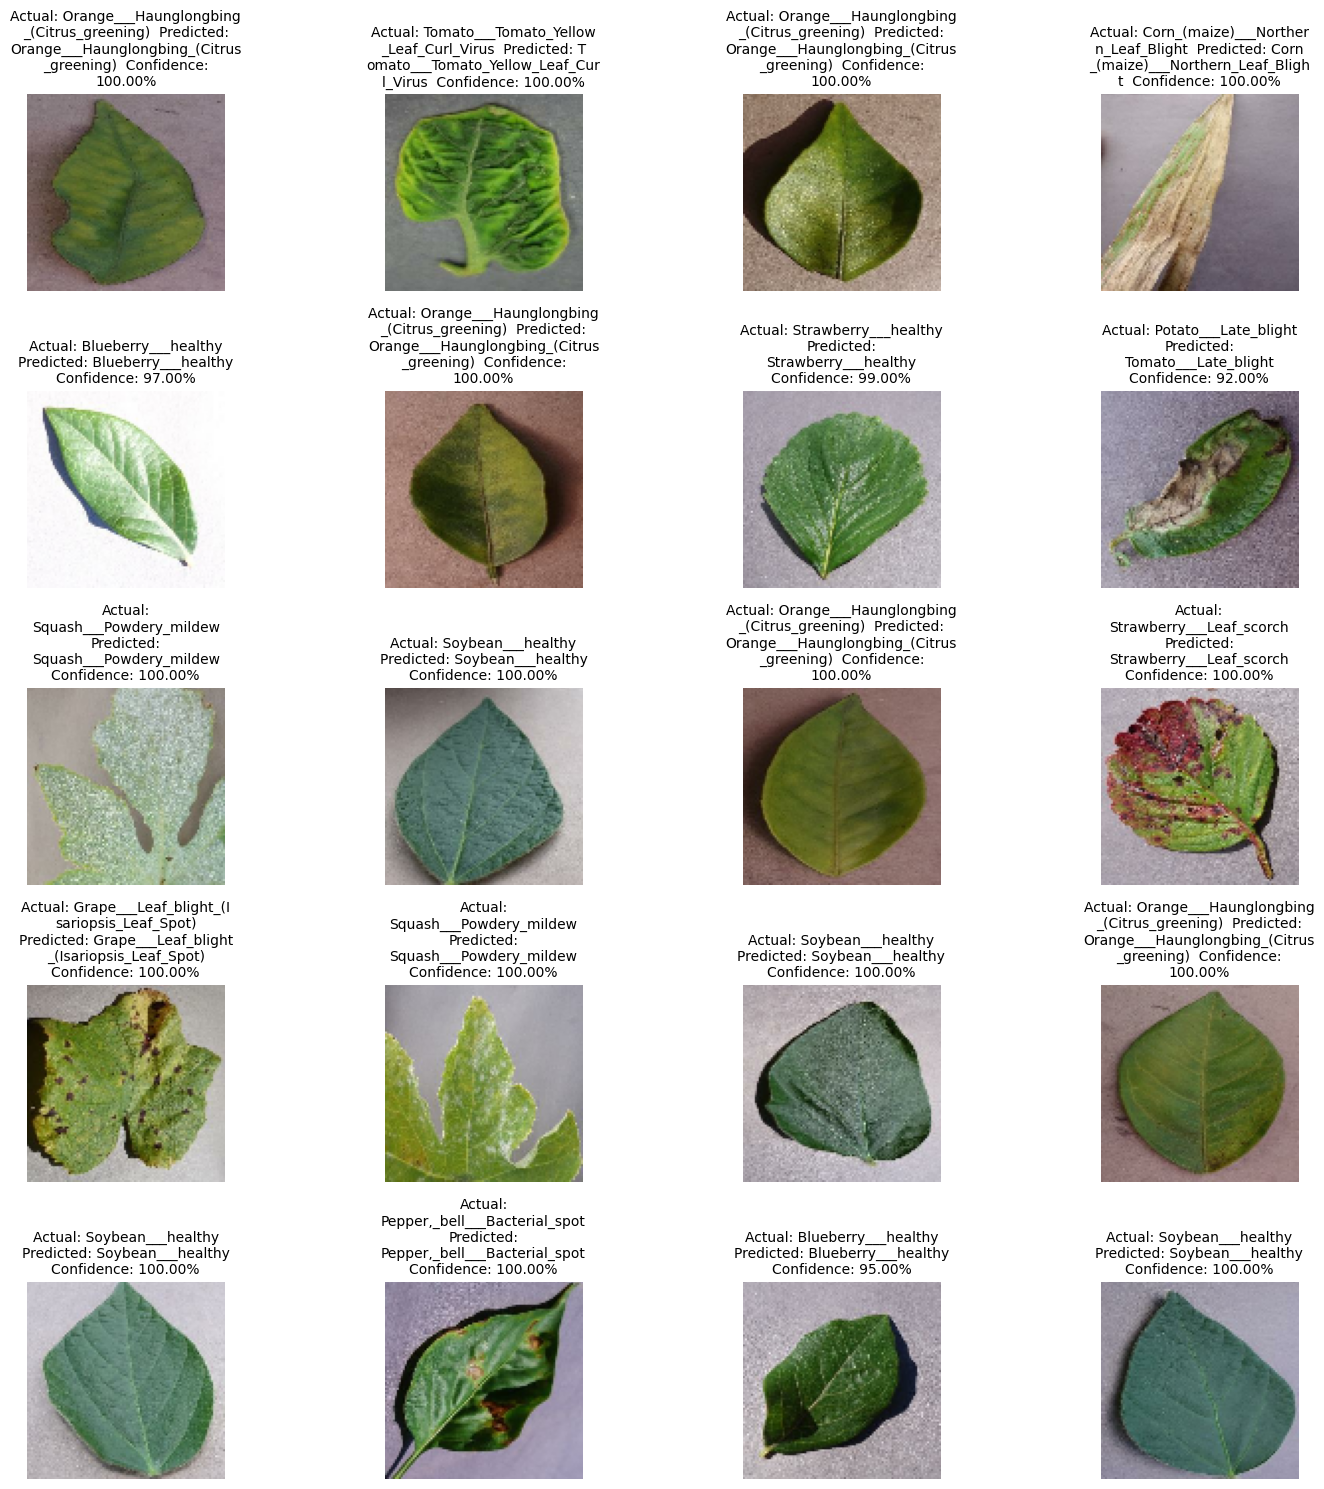

In [11]:
import matplotlib.pyplot as plt
import textwrap

def predict(model, img):
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 0)
    return predicted_class, confidence
    
plt.figure(figsize=(15, 15))
for images, labels in validation_generator.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i+1)  
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        title = (
            f"Actual: {actual_class}\n\n"
            f"Predicted: {predicted_class}\n\n"
            f"Confidence: {confidence:.2f}%"
        )
        wrapped_title = "\n".join(textwrap.wrap(title, width=30))
        plt.title(wrapped_title, fontsize=10)

        plt.axis('off')

plt.tight_layout()
plt.show()


<ipython-input-13-f502ea900763>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


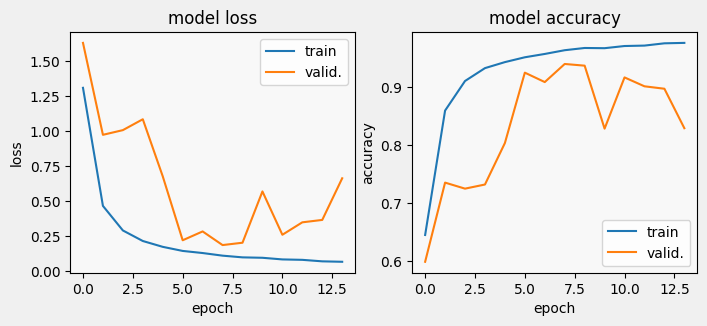

In [13]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(7,3), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 122)

171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


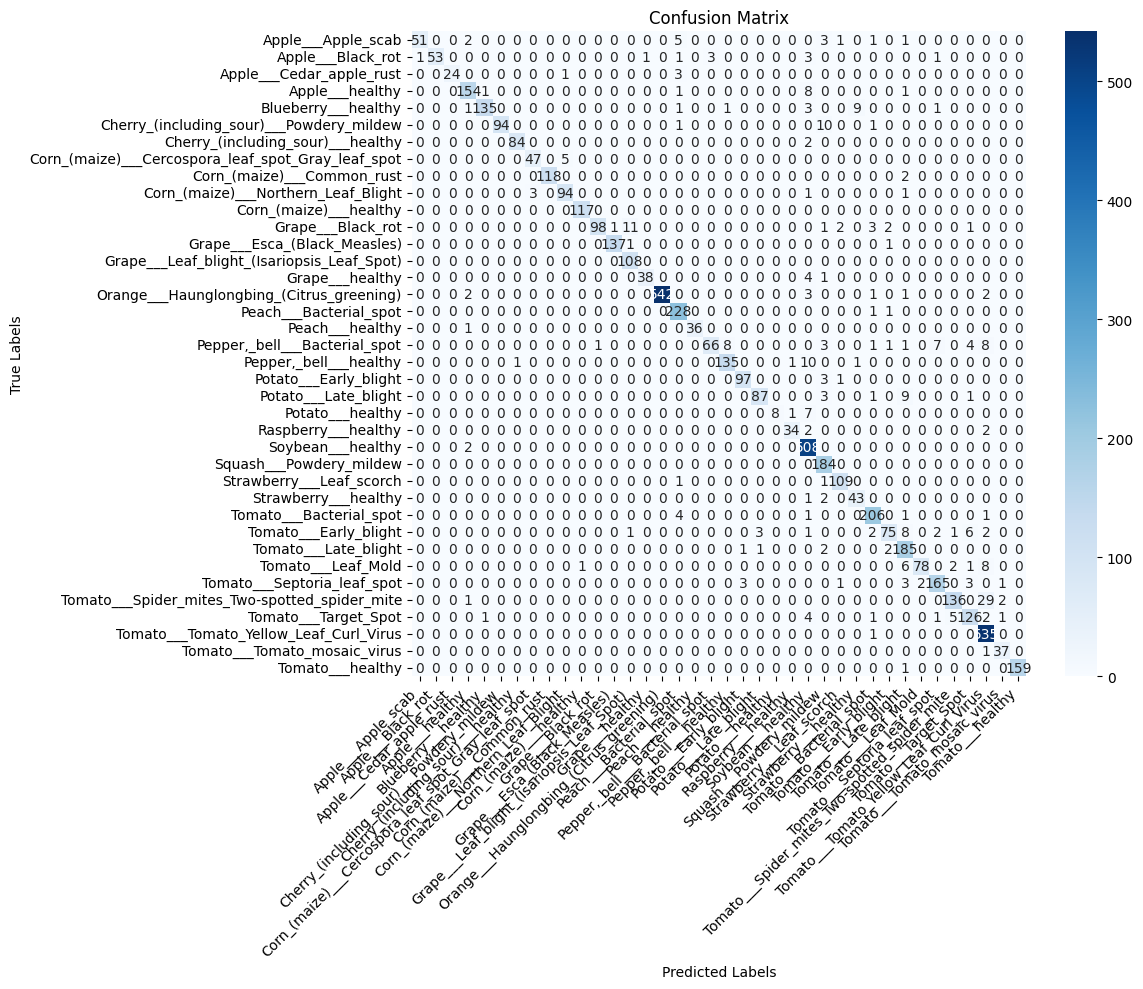

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

class_names = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot",
    "Corn_(maize)___Common_rust",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Raspberry___healthy",
    "Soybean___healthy",
    "Squash___Powdery_mildew",
    "Strawberry___Leaf_scorch",
    "Strawberry___healthy",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites_Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___healthy"
]

y_test_one_hot = to_categorical(y_test, num_classes=len(class_names))

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test_one_hot, axis=1) 

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()


In [42]:
# salveaza modelul
model.save('vres-cnn.keras')  # save the model

In [43]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Necesar in Keras 3 pentru compatibilizare cu formatul TF 
# exporta in format tf export 
model = load_model('vres-cnn.keras')
model.export('some', format="tf_saved_model")
# # incarca modelul exportat 
import tensorflow as tf 
mod=tf.saved_model.load('some')

Saved artifact at 'some'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_217CLONE')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  133220060879280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220060880336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220037743136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220037743312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220023487472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220023495920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133219899248480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220036893104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220036901376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220036898208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133220036889056:

In [44]:
# conversie tf.lite 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
# may be useful : https://medium.com/@hellokhorshed/a-step-by-step-guide-to-convert-keras-model-to-tensorflow-lite-tflite-model-6c8d08707488
# se pot incerca diverse formule de cuantizare de ex. cea de mai jos 
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Salvarea modelului TensorFlow Lite într-un fișier
#tflite_file = f'{model_name}_{dataset}.tflite'
tflite_file='leaf_disease_VRES-CNN.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("Conversia a fost realizată cu succes și modelul a fost salvat ca: ",tflite_file)

Conversia a fost realizată cu succes și modelul a fost salvat ca:  leaf_disease_VRES-CNN.tflite


W0000 00:00:1734514168.613172     311 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1734514168.613204     311 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [45]:
import numpy as np
import tensorflow as tf
import time as ti
from sklearn.metrics import classification_report, confusion_matrix

out_coding = 'cat'  # Helper function, run once

def evaluate_model(interpreter, x_test, y_test):  # num_batches only if you use validation_generator
    # Check if y_test is one-hot encoded or already in class indices
    if y_test.ndim == 2:  # If y_test is one-hot encoded (shape: [num_samples, num_classes])
        ync_test = np.argmax(y_test, axis=1)  # Convert to class indices
    else:  # If y_test is already in class indices (shape: [num_samples])
        ync_test = y_test  # Use it as is
    
    # Get input and output details for the interpreter
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    prediction_digits = []
    durata = 0
    
    # Loop through test images
    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  # Reshape if necessary
        interpreter.set_tensor(input_index, test_image)
        
        t1 = ti.time()
        # Run inference
        interpreter.invoke()
        t2 = ti.time()
        durata += (t2 - t1)
        
        output = interpreter.get_tensor(output_index)  # Get output from the interpreter
        digit = np.argmax(output, axis=1)  # Convert to predicted class (index)
        prediction_digits.append(digit)

    # Confusion matrix and accuracy calculation
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == ync_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)
    
    # Confusion matrix
    C = confusion_matrix(prediction_digits, ync_test)
    print(C)
    print(classification_report(ync_test, prediction_digits))
    
    return accuracy, prediction_digits, 1000 * durata / len(prediction_digits)  # Return accuracy, predictions, and latency

In [47]:
# absolut necesare pentru a se putea lucra mai departe 
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/leaf_disease_VRES-CNN.tflite' )  # 
interpreter.allocate_tensors()

In [48]:
# Assuming you have x_test and y_test prepared correctly
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/leaf_disease_VRES-CNN.tflite')

interpreter.allocate_tensors()
print("Model Sizes:")
!ls -lh | awk '{print $5 "\t" $9}'  # List model size (optional)
# Evaluate the .tflite model
acc, pred, lat = evaluate_model(interpreter, x_test, y_test)
print(f'Validation accuracy on .tflite model is: {100*acc:.2f}%', f'Latency: {lat:.2f} ms')

Model Sizes:


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


	
1.1M	best_model.keras
124K	leaf_disease_VRES-CNN.tflite
4.0K	some
4.0K	split-dataset
1.1M	vres-cnn.keras
[[ 59   0   0 ...   0   0   0]
 [  0  60   0 ...   0   0   0]
 [  0   0  28 ...   0   0   0]
 ...
 [  0   0   0 ... 536   0   0]
 [  0   0   0 ...   0  38   0]
 [  0   0   0 ...   0   0 159]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        64
           1       1.00      0.95      0.98        63
           2       1.00      1.00      1.00        28
           3       0.96      0.98      0.97       165
           4       0.99      0.99      0.99       151
           5       1.00      0.90      0.95       106
           6       0.91      1.00      0.96        86
           7       0.80      1.00      0.89        52
           8       1.00      1.00      1.00       120
           9       1.00      0.84      0.91        99
          10       0.99      1.00      1.00       117
          11       1.00      0.81      0.89       11

In [15]:
# V-CNN Versatile CNN model -
# includes L-CNN, NL-CNN and XNL-CNN as particular cases.
# The basic unit is the "macro-layer" as in the XNL-CNN but here one can independently choose the
# filter size (fil) and
# nonlinearity nl (0 means "linear" convolution)
# It allows any number of additional dense layers e.g. hid=[] (no hidden dense) or hid =[100, 100] (two additional).
# Copyright Radu and Ioana DOGARU - correspondence: radu.dogaru@upb.ro
# Last update June 21, 2023
#-------------------------------------------------------------------------------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam

#--------------------------  ------------------------------
def create_v_cnn_model(input_shape, num_classes, flat=1, fil=[100,100,100,100], nl=[1,1,0,0], hid=[]):
    # Note the number of elements in fil list (macrolayers) should be the same in nl list
    # hid can be [] while if the are elements, additional dense layers are added in the output classifier

    csize=3; stri=2; psiz=4; pad='same';
    drop1=0.3

    nfilmax=np.shape(np.array(fil))[0]
    model2 = Sequential()
    # First macrolayer - connected to input  ----------------
    layer=0
    if nl[layer]>0:
        model2.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model2.add(Activation('relu'))
        for nonlin in range(1,nl[0]):
            model2.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model2.add(Activation('relu'))

        model2.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize) ) )
        model2.add(BatchNormalization())
        model2.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model2.add(Dropout(drop1))

    else:
        model2.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model2.add(BatchNormalization())
        model2.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model2.add(Dropout(drop1))
    # The remaining  macro-layers

    for layer in range(1,nfilmax):
        #------------------ nonlin layers -----------------
        for nonlin in range(nl[layer]):
            model2.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model2.add(Activation('relu'))

        #----------------- default macrolayer output

        model2.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
        model2.add(BatchNormalization())
        model2.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model2.add(Dropout(drop1))

    # Exit classifier
    # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice )
    if flat==1:
        model2.add(Flatten())  # alternanta cu GlobalAv ..
    elif flat==0:
        model2.add(GlobalAveragePooling2D()) # pare sa fie mai Ok la cifar
    nhid=np.shape(np.array(hid))[0]
    if nhid>0:
        for lay in range(nhid):
            model2.add(Dense(hid[lay], activation='relu'))
            #model.add(Dropout(drop1))
    model2.add(Dense(num_classes, activation='softmax'))

# END OF MODEL DESCRIPTION
    model2.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
    return model2



In [16]:
# create the V-CNN with specified parameters
model2=create_v_cnn_model(input_shape, num_classes, flat=0, fil=[50,150,150,50], nl=[1,1,0,0], hid=[])
model2.summary()
print(len(model2.layers))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 50)        │           1,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 100, 100, 50)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 50)        │          22,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100, 100, 50)        │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 50, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 150)         │          67,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 50, 50, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 150)         │         202,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 50, 150)         │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 25, 25, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 150)         │         202,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 25, 25, 150)         │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 13, 13, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 50)          │          67,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 13, 13, 50)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 567,988 (2.17 MB)

 Trainable params: 567,188 (2.16 MB)

 Non-trainable params: 800 (3.12 KB)

22


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='leafvcnn.keras', 
    monitor='val_accuracy',     
    save_best_only=True,         
    mode='max',                 
    verbose=1           
)

In [18]:
from tensorflow.keras.utils import to_categorical
import time as ti
from keras.models import load_model

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

epoci = 10
t1=ti.time()   

history = model2.fit(
    x_train, y_train_one_hot,               
    epochs=epoci,  
    validation_data=(x_test, y_test_one_hot), 
    batch_size=batch_size,                  
    verbose=2,                              
    callbacks=[checkpoint]                   
)
   
t2=ti.time()   #save the time when training ended
print('====================================================')
print('Training with  ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')
t1=ti.time()   # save the time when the model started to load
model2=load_model('leafvcnn.keras')  #load the best model saved during training
bp=model2.get_weights()  # best weights set
score = model2.evaluate(x_test, y_test_one_hot, verbose=0) #evaluate the model on the test data
t2=ti.time()   #save the time when the evaluation process ended
loss, accuracy = score  # Unpack the evaluation metrics
print(f"Total number of parameters: {model2.count_params()}")
print(f"Best validation accuracy: {accuracy * 100:.2f}%")
print(f"Loss on test set: {loss:.4f}")
print(f"Time to predict on the entire test set: {t2 - t1:.2f} seconds")
print(f"Latency - GPU (per sample): {1000 * (t2 - t1) / np.shape(x_test)[0]:.2f} ms")

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.70211, saving model to leafvcnn.keras
760/760 - 64s - 84ms/step - accuracy: 0.6672 - loss: 1.2688 - val_accuracy: 0.7021 - val_loss: 0.9428
Epoch 2/10

Epoch 2: val_accuracy improved from 0.70211 to 0.74372, saving model to leafvcnn.keras
760/760 - 40s - 52ms/step - accuracy: 0.8797 - loss: 0.4400 - val_accuracy: 0.7437 - val_loss: 0.8569
Epoch 3/10

Epoch 3: val_accuracy improved from 0.74372 to 0.80513, saving model to leafvcnn.keras
760/760 - 40s - 52ms/step - accuracy: 0.9229 - loss: 0.2685 - val_accuracy: 0.8051 - val_loss: 0.6252
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.80513
760/760 - 40s - 52ms/step - accuracy: 0.9391 - loss: 0.1999 - val_accuracy: 0.7998 - val_loss: 0.7190
Epoch 5/10

Epoch 5: val_accuracy improved from 0.80513 to 0.85866, saving model to leafvcnn.keras
760/760 - 40s - 52ms/step - accuracy: 0.9525 - loss: 0.1585 - val_accuracy: 0.8587 - val_loss: 0.4889
Epoch 6/10

Epoch 6: val_accuracy 

In [ ]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Necesar in Keras 3 pentru compatibilizare cu formatul TF 
# exporta in format tf export 
model = load_model('leafvcnn.keras')
model.export('some', format="leafvcnn.tflite")
# # incarca modelul exportat 
import tensorflow as tf 
mod=tf.saved_model.load('some')

In [ ]:
# conversie tf.lite 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
# may be useful : https://medium.com/@hellokhorshed/a-step-by-step-guide-to-convert-keras-model-to-tensorflow-lite-tflite-model-6c8d08707488
# se pot incerca diverse formule de cuantizare de ex. cea de mai jos 
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Salvarea modelului TensorFlow Lite într-un fișier
#tflite_file = f'{model_name}_{dataset}.tflite'
tflite_file='leafvcnn.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("Conversia a fost realizată cu succes și modelul a fost salvat ca: ",tflite_file)

In [ ]:
import numpy as np
import tensorflow as tf
import time as ti
from sklearn.metrics import classification_report, confusion_matrix

out_coding = 'cat'  # Helper function, run once

def evaluate_model(interpreter, x_test, y_test):  # num_batches only if you use validation_generator
    # Check if y_test is one-hot encoded or already in class indices
    if y_test.ndim == 2:  # If y_test is one-hot encoded (shape: [num_samples, num_classes])
        ync_test = np.argmax(y_test, axis=1)  # Convert to class indices
    else:  # If y_test is already in class indices (shape: [num_samples])
        ync_test = y_test  # Use it as is
    
    # Get input and output details for the interpreter
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    prediction_digits = []
    durata = 0
    
    # Loop through test images
    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  # Reshape if necessary
        interpreter.set_tensor(input_index, test_image)
        
        t1 = ti.time()
        # Run inference
        interpreter.invoke()
        t2 = ti.time()
        durata += (t2 - t1)
        
        output = interpreter.get_tensor(output_index)  # Get output from the interpreter
        digit = np.argmax(output, axis=1)  # Convert to predicted class (index)
        prediction_digits.append(digit)

    # Confusion matrix and accuracy calculation
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == ync_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)
    
    # Confusion matrix
    C = confusion_matrix(prediction_digits, ync_test)
    print(C)
    print(classification_report(ync_test, prediction_digits))
    
    return accuracy, prediction_digits, 1000 * durata / len(prediction_digits)  # Return accuracy, predictions, and latency

In [ ]:
# absolut necesare pentru a se putea lucra mai departe 
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/leafvcnn.tflite' )  # 
interpreter.allocate_tensors()

In [ ]:
# Assuming you have x_test and y_test prepared correctly
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/leafvcnn.tflite' )

interpreter.allocate_tensors()
print("Model Sizes:")
!ls -lh | awk '{print $5 "\t" $9}'  # List model size (optional)
# Evaluate the .tflite model
acc, pred, lat = evaluate_model(interpreter, x_test, y_test)
print(f'Validation accuracy on .tflite model is: {100*acc:.2f}%', f'Latency: {lat:.2f} ms')

In [15]:
!pip install -U --pre efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [16]:
import efficientnet.tfkeras as efn
import tensorflow as tf

def get_efficientNet_model(input_shape, num_classes):
    enet = efn.EfficientNetB0(
        input_shape=input_shape,
        weights='noisy-student',
        include_top=False
    )

    model3 = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model3

# Define parameters
img_size = (100, 100, 3)  # Ensure this is correctly defined
num_classes = 38  # Change as per your dataset

# Get the model
model3 = get_efficientNet_model(img_size, num_classes)

# Compile the model
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model3.summary()


16696600/16696600 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)         │ (None, 4, 4, 1280)          │       4,049,564 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │          48,678 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,098,242 (15.63 MB)

 Trainable params: 4,056,226 (15.47 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [19]:
augment=0   # 0 - non-augmented (fast training) 1,2,3 .. various schemes ..
# ----------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
if augment==1:
  data_generator = ImageDataGenerator(
                        ### --- useful for FER2013 ---

                          featurewise_center=False,
                          featurewise_std_normalization=False,
                          rotation_range=10,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          zoom_range=.1,
                          horizontal_flip=True
                          )

                        #------- useful for CIFAR10 according to https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-
elif augment==2:
  data_generator = ImageDataGenerator(
                          rotation_range=15,
                          horizontal_flip=True,
                          width_shift_range=0.1,
                          height_shift_range=0.1
                        #------------------------------
                         )
elif augment==3:      # Proposed in https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb
  data_generator = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)




In [20]:
checkpoint = ModelCheckpoint('effffff.keras', 
                             monitor='val_accuracy', 
                             mode='max', 
                             save_best_only=True, 
                             verbose=1)  # Ensure correct format


In [21]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import time as ti
import numpy as np
from tensorflow.keras.utils import to_categorical

# Ensure reproducibility
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Assuming x_train, x_test, y_train, y_test are already loaded
num_classes = 38  # Update this with your actual number of classes
batch_size = 100  
epoci = 20  

# 🔹 Convert labels to categorical (One-Hot Encoding)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Checkpoint to save the best model
checkpoint = ModelCheckpoint('effffff.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# 🔹 Training
t1 = ti.time()
if augment == 0:
    history = model3.fit(
        x_train, y_train,
        epochs=epoci,
        validation_data=(x_test, y_test),
        batch_size=batch_size,
        verbose=2,
        callbacks=[checkpoint]
    )
elif augment > 0:
    history = model3.fit(
        data_generator.flow(x_train, y_train, batch_size=batch_size),
        epochs=epoci,
        validation_data=(x_test, y_test),
        verbose=2,
        callbacks=[checkpoint]
    )
t2 = ti.time()

print('====================================================')
print('Training with', epoci, 'epochs, lasted', int((t2 - t1) / 60), 'minutes')

# 🔹 Load Best Model
t1 = ti.time()
model3 = load_model('effffff.keras')
bp = model3.get_weights()  

# 🔹 Evaluate
score = model3.evaluate(x_test, y_test, verbose=0)
t2 = ti.time()

print('Total number of parameters:', model3.count_params())
print('Best validation accuracy:', 100 * score[1], '%')
print('Latency - GPU (per sample):', 1000 * (t2 - t1) / np.shape(x_test)[0], 'ms')


Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.96004, saving model to effffff.keras
380/380 - 140s - 369ms/step - accuracy: 0.9233 - loss: 0.2693 - val_accuracy: 0.9600 - val_loss: 0.1566
Epoch 2/20

Epoch 2: val_accuracy improved from 0.96004 to 0.96444, saving model to effffff.keras
380/380 - 35s - 91ms/step - accuracy: 0.9842 - loss: 0.0475 - val_accuracy: 0.9644 - val_loss: 0.1108
Epoch 3/20

Epoch 3: val_accuracy improved from 0.96444 to 0.97049, saving model to effffff.keras
380/380 - 35s - 91ms/step - accuracy: 0.9876 - loss: 0.0390 - val_accuracy: 0.9705 - val_loss: 0.0969
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.97049
380/380 - 34s - 89ms/step - accuracy: 0.9898 - loss: 0.0335 - val_accuracy: 0.9676 - val_loss: 0.1239
Epoch 5/20

Epoch 5: val_accuracy improved from 0.97049 to 0.97324, saving model to effffff.keras
380/380 - 35s - 91ms/step - accuracy: 0.9915 - loss: 0.0262 - val_accuracy: 0.9732 - val_loss: 0.0985
Epoch 6/20

Epoch 6: val_accuracy di

In [ ]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Necesar in Keras 3 pentru compatibilizare cu formatul TF 
# exporta in format tf export 
model = load_model('effffff.keras')
model.export('some', format="effffff.tflite")
# # incarca modelul exportat 
import tensorflow as tf 
mod=tf.saved_model.load('some')

In [ ]:
# conversie tf.lite 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
# may be useful : https://medium.com/@hellokhorshed/a-step-by-step-guide-to-convert-keras-model-to-tensorflow-lite-tflite-model-6c8d08707488
# se pot incerca diverse formule de cuantizare de ex. cea de mai jos 
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Salvarea modelului TensorFlow Lite într-un fișier
#tflite_file = f'{model_name}_{dataset}.tflite'
tflite_file='effffff.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("Conversia a fost realizată cu succes și modelul a fost salvat ca: ",tflite_file)

In [ ]:
import numpy as np
import tensorflow as tf
import time as ti
from sklearn.metrics import classification_report, confusion_matrix

out_coding = 'cat'  # Helper function, run once

def evaluate_model(interpreter, x_test, y_test):  # num_batches only if you use validation_generator
    # Check if y_test is one-hot encoded or already in class indices
    if y_test.ndim == 2:  # If y_test is one-hot encoded (shape: [num_samples, num_classes])
        ync_test = np.argmax(y_test, axis=1)  # Convert to class indices
    else:  # If y_test is already in class indices (shape: [num_samples])
        ync_test = y_test  # Use it as is
    
    # Get input and output details for the interpreter
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    prediction_digits = []
    durata = 0
    
    # Loop through test images
    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  # Reshape if necessary
        interpreter.set_tensor(input_index, test_image)
        
        t1 = ti.time()
        # Run inference
        interpreter.invoke()
        t2 = ti.time()
        durata += (t2 - t1)
        
        output = interpreter.get_tensor(output_index)  # Get output from the interpreter
        digit = np.argmax(output, axis=1)  # Convert to predicted class (index)
        prediction_digits.append(digit)

    # Confusion matrix and accuracy calculation
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == ync_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)
    
    # Confusion matrix
    C = confusion_matrix(prediction_digits, ync_test)
    print(C)
    print(classification_report(ync_test, prediction_digits))
    
    return accuracy, prediction_digits, 1000 * durata / len(prediction_digits)  # Return accuracy, predictions, and latency

In [ ]:
# absolut necesare pentru a se putea lucra mai departe 
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/effffff.tflite' )  # 
interpreter.allocate_tensors()

In [ ]:
# Assuming you have x_test and y_test prepared correctly
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/effffff.tflite' )

interpreter.allocate_tensors()
print("Model Sizes:")
!ls -lh | awk '{print $5 "\t" $9}'  # List model size (optional)
# Evaluate the .tflite model
acc, pred, lat = evaluate_model(interpreter, x_test, y_test)
print(f'Validation accuracy on .tflite model is: {100*acc:.2f}%', f'Latency: {lat:.2f} ms')